# Hi :)

----

# Import libraries

In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialization

In [9]:
# Dataset and DataLoader
class CNNFeatureDataset(Dataset):
    def __init__(self, X, y):
        self.X= torch.tensor(X, dtype= torch.float32)
        self.y= torch.tensor(y, dtype= torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.network= nn.Sequential(
            nn.Conv1d(1, 16, kernel_size= 2),  # output: [batch, 16, 2]
            nn.ReLU(),
            nn.Flatten(),  # [batch, 16 * 2]
            nn.Linear(16 * 2, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Binary classification (output: logits for 2 classes)
        )

    def forward(self, x):
        return self.network(x)

# ITG

# Loading the dataset

In [4]:
ITG_features_df= pd.read_csv('Dataset/ITG_features_df.csv')

# CNN

In [ ]:
# Step 1: Extract features and labels
X= ITG_features_df[['F1_sum_vector_magnitude', 'F2_orientation_angle', 'F3_std_magnitude']].values
y= ITG_features_df['Situation'].values

# Step 2: Encode labels ('Fall' → 1, 'Not Fall' → 0)
label_encoder= LabelEncoder()
y_encoded= label_encoder.fit_transform(y)

# Step 3: Normalize features
scaler= StandardScaler()
X= scaler.fit_transform(X)

# Step 4: Reshape to 1D-CNN format: (samples, channels= 1, timesteps= 3)
X= X.reshape((X.shape[0], 1, X.shape[1]))

# Step 5: Split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y_encoded, test_size= 0.2, random_state= 48, stratify= y_encoded)

In [7]:
# Step 6: Dataset and DataLoader
train_loader= DataLoader(CNNFeatureDataset(X_train, y_train), batch_size= 16, shuffle= True)
test_loader= DataLoader(CNNFeatureDataset(X_test, y_test), batch_size= 16)

In [16]:
# Step 7: Train CNN
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= SimpleCNN().to(device)

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)

for epoch in range(20):
    model.train()
    total_loss= 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch= X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out= model(X_batch)
        loss= criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 673.3182
Epoch 2, Loss: 654.5667
Epoch 3, Loss: 649.4370
Epoch 4, Loss: 647.1867
Epoch 5, Loss: 645.9639
Epoch 6, Loss: 643.3156
Epoch 7, Loss: 641.4247
Epoch 8, Loss: 640.4320
Epoch 9, Loss: 638.9511
Epoch 10, Loss: 637.2766
Epoch 11, Loss: 636.0247
Epoch 12, Loss: 634.5859
Epoch 13, Loss: 632.8539
Epoch 14, Loss: 631.5299
Epoch 15, Loss: 630.5744
Epoch 16, Loss: 631.4525
Epoch 17, Loss: 628.7779
Epoch 18, Loss: 628.1653
Epoch 19, Loss: 627.9321
Epoch 20, Loss: 627.8774


Accuracy: 0.6752503576537912
Classification Report:
               precision    recall  f1-score   support

        Fall       0.65      0.75      0.70      2097
    Not Fall       0.71      0.60      0.65      2097

    accuracy                           0.68      4194
   macro avg       0.68      0.68      0.67      4194
weighted avg       0.68      0.68      0.67      4194



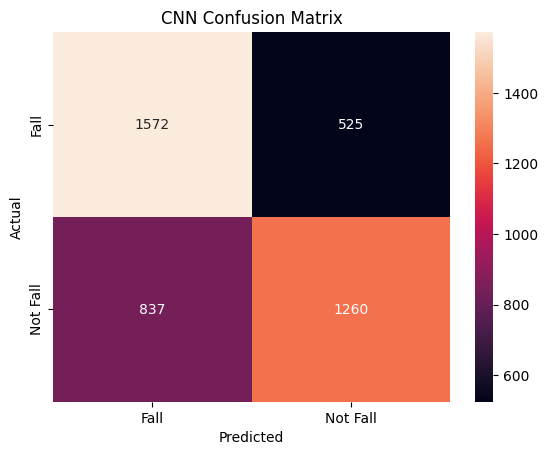

In [18]:
# Step 8: Evaluation
model.eval()
all_preds= []
all_true= []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch= X_batch.to(device)
        outputs= model(X_batch)
        _, predicted= torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(y_batch.numpy())

print("Accuracy:", accuracy_score(all_true, all_preds))
print("Classification Report:\n", classification_report(all_true, all_preds, target_names= label_encoder.classes_))

# Confusion Matrix
cm= confusion_matrix(all_true, all_preds)
sns.heatmap(cm, annot= True, fmt= 'd', xticklabels= label_encoder.classes_, yticklabels= label_encoder.classes_)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

----

# Data Fusion

# Loading the dataset

In [19]:
KF_features_df= pd.read_csv('Dataset/KF_features_df.csv')

# CNN

In [20]:
# Step 1: Extract features and labels
X= KF_features_df[['F1_sum_vector_magnitude', 'F2_orientation_angle', 'F3_std_magnitude']].values
y= KF_features_df['Situation'].values

# Step 2: Encode labels ('Fall' → 1, 'Not Fall' → 0)
label_encoder= LabelEncoder()
y_encoded= label_encoder.fit_transform(y)

# Step 3: Normalize features
scaler= StandardScaler()
X= scaler.fit_transform(X)

# Step 4: Reshape to 1D-CNN format: (samples, channels= 1, timesteps= 3)
X= X.reshape((X.shape[0], 1, X.shape[1]))

# Step 5: Split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y_encoded, test_size= 0.2, random_state= 48, stratify= y_encoded)

In [21]:
# Step 6: Dataset and DataLoader
train_loader= DataLoader(CNNFeatureDataset(X_train, y_train), batch_size= 16, shuffle= True)
test_loader= DataLoader(CNNFeatureDataset(X_test, y_test), batch_size= 16)

In [22]:
# Step 7: Train CNN
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= SimpleCNN().to(device)

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)

for epoch in range(20):
    model.train()
    total_loss= 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch= X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out= model(X_batch)
        loss= criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 569.1123
Epoch 2, Loss: 548.0420
Epoch 3, Loss: 538.3863
Epoch 4, Loss: 532.3237
Epoch 5, Loss: 528.4084
Epoch 6, Loss: 525.1506
Epoch 7, Loss: 523.0890
Epoch 8, Loss: 521.1240
Epoch 9, Loss: 520.0214
Epoch 10, Loss: 517.9118
Epoch 11, Loss: 517.0802
Epoch 12, Loss: 515.7394
Epoch 13, Loss: 514.3798
Epoch 14, Loss: 512.6888
Epoch 15, Loss: 511.2780
Epoch 16, Loss: 509.8393
Epoch 17, Loss: 508.2694
Epoch 18, Loss: 507.4239
Epoch 19, Loss: 505.2150
Epoch 20, Loss: 504.3107


Accuracy: 0.7753934191702432
Classification Report:
               precision    recall  f1-score   support

        Fall       0.80      0.73      0.77      2097
    Not Fall       0.75      0.82      0.78      2097

    accuracy                           0.78      4194
   macro avg       0.78      0.78      0.77      4194
weighted avg       0.78      0.78      0.77      4194



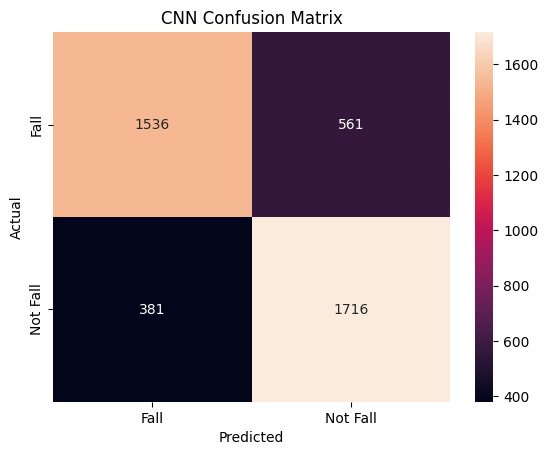

In [23]:
# Step 8: Evaluation
model.eval()
all_preds= []
all_true= []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch= X_batch.to(device)
        outputs= model(X_batch)
        _, predicted= torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(y_batch.numpy())

print("Accuracy:", accuracy_score(all_true, all_preds))
print("Classification Report:\n", classification_report(all_true, all_preds, target_names= label_encoder.classes_))

# Confusion Matrix
cm= confusion_matrix(all_true, all_preds)
sns.heatmap(cm, annot= True, fmt= 'd', xticklabels= label_encoder.classes_, yticklabels= label_encoder.classes_)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()